# SSH changes

In [1]:
import cmocean 
import cosima_cookbook as cc
import dask.distributed as dsk
import gsw
import glob
import matplotlib.gridspec as gs
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import xarray as xr

import warnings # ignore these warnings
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = UserWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning)

figdir = '/home/561/jn8053/g_e14/figures-tmp/easterlies-collaborative/'

clnt = dsk.Client()
clnt

Client Scheduler: tcp://127.0.0.1:41247 Dashboard: /proxy/8787/status,Cluster Workers: 4 Cores: 16 Memory: 64.00 GiB


Load datasets

In [2]:
session_ryf = cc.database.create_session()
experiment_ryf = '01deg_jra55v13_ryf9091'
session_eas = cc.database.create_session('/g/data/v45/akm157/model_data/access-om2/01deg_jra55v13_ryf9091_easterlies_up10/easterlies.db')
experiment_eup = '01deg_jra55v13_ryf9091_easterlies_up10'
experiment_edo = '01deg_jra55v13_ryf9091_easterlies_down10'

ti = '2150-01-01'
tf = '2164-12-31'

In [3]:
ht = cc.querying.getvar(experiment_ryf, 'ht', session_ryf, n = 1).sel(yt_ocean = slice(None, -58))
iso = xr.open_dataset('~/g_e14/misc/Antarctic_isobath_1000m.nc')

In [54]:
slev = {}
slev['ctrl'] = cc.querying.getvar(experiment_ryf, 'sea_level', session_ryf, start_time = ti, end_time = '2169-12-31').sel(time = slice(ti, '2169-12-31'), yt_ocean = slice(None, -58))
slev['up'] = cc.querying.getvar(experiment_eup, 'sea_level', session_eas, start_time = ti, end_time = tf).sel(yt_ocean = slice(None, -58))
slev['down'] = cc.querying.getvar(experiment_edo, 'sea_level', session_eas, start_time = ti, end_time = tf).sel(yt_ocean = slice(None, -58))

# Time series for continental shelf

### Sea level

In [56]:
lat_slice = slice(-80,-58)
lon_slice = slice(-280, 80)

def shelf_mask_isobath(var):
    '''
    Masks ACCESS-OM2-01 variables by the region polewards of the 1000m isobath as computed using 
    a script contributed by Adele Morrison.
    Only to be used with ACCESS-OM2-0.1 output!
    '''
    contour_file = np.load('/g/data/ik11/grids/Antarctic_slope_contour_1000m.npz')
    shelf_mask = contour_file['contour_masked_above']
    yt_ocean = contour_file['yt_ocean']
    xt_ocean = contour_file['xt_ocean']
    # Mask values that are non-zero
    shelf_mask[np.where(shelf_mask!=0)] = np.nan
    shelf_mask = shelf_mask+1
    shelf_map = np.nan_to_num(shelf_mask)
    shelf_mask = xr.DataArray(shelf_mask, coords = [('yt_ocean', yt_ocean), ('xt_ocean', xt_ocean)])
    shelf_map = xr.DataArray(shelf_map, coords = [('yt_ocean', yt_ocean), ('xt_ocean', xt_ocean)])
    # Multiply the variable with the mask, we need to account for the shape of the mask. 
    # The mask uses a northern cutoff of 59S.
    masked_var = var.sel(yt_ocean = lat_slice) * shelf_mask
    return masked_var, shelf_map

In [57]:
slev_mask = {}
for k in ['ctrl', 'up', 'down']:
    slev_mask[k], shelf_mask = shelf_mask_isobath(slev[k])

In [58]:
# Area for weighting
area_t = cc.querying.getvar(experiment_ryf, 'area_t', session_ryf, ncfile = 'ocean_grid.nc', n = -1)
area_t = area_t.sel(yt_ocean = lat_slice).sel(xt_ocean = lon_slice)
area_t = area_t * shelf_mask.sel(yt_ocean = lat_slice).sel(xt_ocean = lon_slice)
area_sum = area_t.sum('xt_ocean').sum('yt_ocean')

In [59]:
slev_clim_control = ((slev_mask['ctrl']*area_t).sum('xt_ocean').sum('yt_ocean') / area_sum).groupby('time.month').mean('time')
slev_anom_mask = {}
for k in ['up', 'down']:
    slev_anom_mask[k] = ((slev_mask[k]*area_t).sum('xt_ocean').sum('yt_ocean') / area_sum).groupby('time.month') - slev_clim_control

### DSW export

In [12]:
path_up = np.sort(glob.glob('/g/data/v45/akm157/model_data/access-om2/01deg_jra55v13_ryf9091_easterlies_up10/Antarctic_cross_slope/*'))

vol_transp_up = xr.open_dataset('/g/data/v45/akm157/model_data/access-om2/01deg_jra55v13_ryf9091_easterlies_up10/Antarctic_cross_slope/vol_trans_across_contour_2150_01.nc')

for i in range(1, len(path_up)):
    vol_transp_up = xr.concat([vol_transp_up, xr.open_dataset(path_up[i])], dim = 'time')
    
vol_transp_up['time'] = slev_anom_mask['up']['time'].values
vol_transp_up_total = (vol_transp_up['vol_trans_across_contour_binned']*vol_transp_up['ndays']).sum('time')/np.sum(vol_transp_up['ndays'])

In [16]:
path_down = np.sort(glob.glob('/g/data/v45/akm157/model_data/access-om2/01deg_jra55v13_ryf9091_easterlies_down10/Antarctic_cross_slope/*'))

vol_transp_do = xr.open_dataset('/g/data/v45/akm157/model_data/access-om2/01deg_jra55v13_ryf9091_easterlies_down10/Antarctic_cross_slope/vol_trans_across_contour_2150_01.nc')
for i in range(1, len(path_down)):
    vol_transp_do = xr.concat([vol_transp_do, xr.open_dataset(path_down[i])], dim = 'time')
    
vol_transp_do['time'] = slev_anom_mask['up']['time'].values
vol_transp_do_total = (vol_transp_do['vol_trans_across_contour_binned']*vol_transp_do['ndays']).sum('time')/np.sum(vol_transp_do['ndays'])

In [17]:
vol_transp_up_tv = vol_transp_up['vol_trans_across_contour_binned']
vol_transp_do_tv = vol_transp_do['vol_trans_across_contour_binned']

trans_sum_up_tv = vol_transp_up_tv.sum('contour_index')
trans_sum_do_tv = vol_transp_do_tv.sum('contour_index')

psi_up_tv = trans_sum_up_tv[:,::-1].cumsum('isopycnal_bins')[:, ::-1]
psi_do_tv = trans_sum_do_tv[:,::-1].cumsum('isopycnal_bins')[:, ::-1]

In [18]:
DSW_export_up = np.empty(len(psi_up_tv['time']))
DSW_export_do = np.empty(len(psi_do_tv['time']))
# find max DSW density:
DSW_top_density_up = psi_up_tv.argmax('isopycnal_bins')
# find max DSW density:
DSW_top_density_do = psi_do_tv.argmax('isopycnal_bins')

n = 0
for t in psi_up_tv['time']:
    
    # sum over DSW layer:
    DSW_trans_up = psi_up_tv.sel(time = t).isel(isopycnal_bins = int(DSW_top_density_up.sel(time = t)))
    DSW_export_up[n] = DSW_trans_up.item()/1e6
    
    # sum over DSW layer:
    DSW_trans_do = psi_do_tv.sel(time = t).isel(isopycnal_bins = int(DSW_top_density_do.sel(time = t)))
    DSW_export_do[n] = DSW_trans_do.item()/1e6
    n += 1

Fix missing years

In [39]:
idx_to_correct = [129, 130, 131]
fill_value_1 = np.mean([DSW_export_do[129-12], DSW_export_do[129+12]])
fill_value_2 = np.mean([DSW_export_do[130-12], DSW_export_do[130+12]])
fill_value_3 = np.mean([DSW_export_do[131-12], DSW_export_do[131+12]])

In [43]:
DSW_export_do[129] = fill_value_1
DSW_export_do[130] = fill_value_2
DSW_export_do[131] = fill_value_3

In [46]:
DSW_export_up = xr.DataArray(DSW_export_up, dims = ['time'], coords = {'time':slev_anom_mask['up']['time']})
DSW_export_do = xr.DataArray(DSW_export_do, dims = ['time'], coords = {'time':slev_anom_mask['up']['time']})

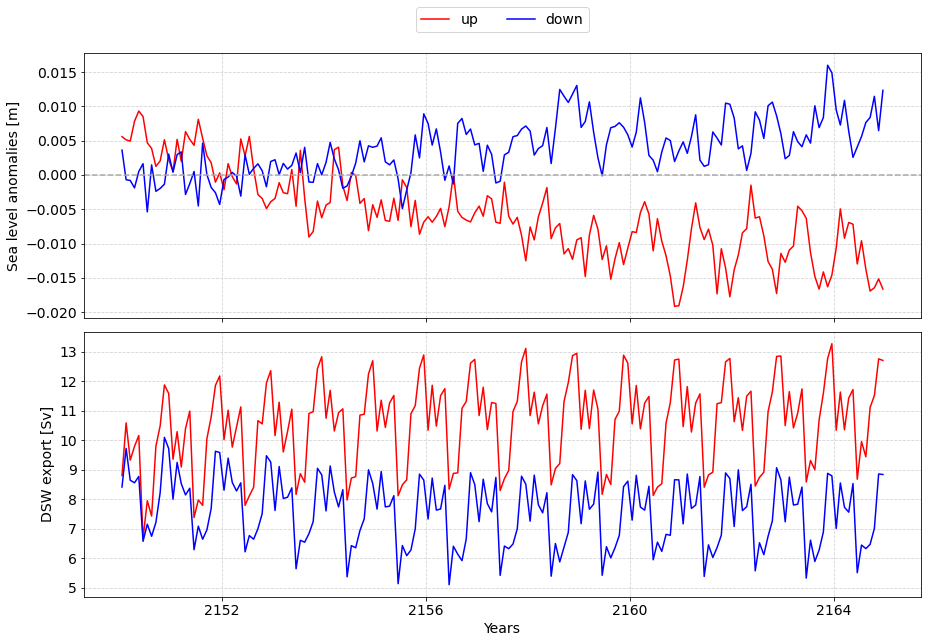

In [62]:
plt.rcParams['font.size'] = 14
fig = plt.figure(figsize = (15, 10))
axs = [fig.add_subplot(211), fig.add_subplot(212)]
plt.subplots_adjust(hspace = 0.05)

for k, clr in zip(['up', 'down'], ['r', 'b']):
    axs[0].plot(slev_anom_mask[k]['time'], slev_anom_mask[k], color = clr, label = k)
axs[1].plot(DSW_export_up['time'], DSW_export_up, color = 'r')
axs[1].plot(DSW_export_do['time'], DSW_export_do, color = 'b')

axs[0].legend(ncol = 2, loc = 'upper center', bbox_to_anchor = (0.5,1.2))

axs[0].set_xticklabels([])
axs[0].axhline(y = 0, color = 'darkgrey', linestyle = '--')
axs[0].grid(linestyle = '--', color = 'lightgrey')
axs[1].grid(linestyle = '--', color = 'lightgrey')
axs[0].set_ylabel('Sea level anomalies [m]')
axs[1].set_xlabel('Years')
axs[1].set_ylabel('DSW export [Sv]')

plt.savefig(figdir+'figure-2-v1.jpg', bbox_inches = 'tight')

With rolling mean

Text(0, 0.5, 'DSW export [Sv]')

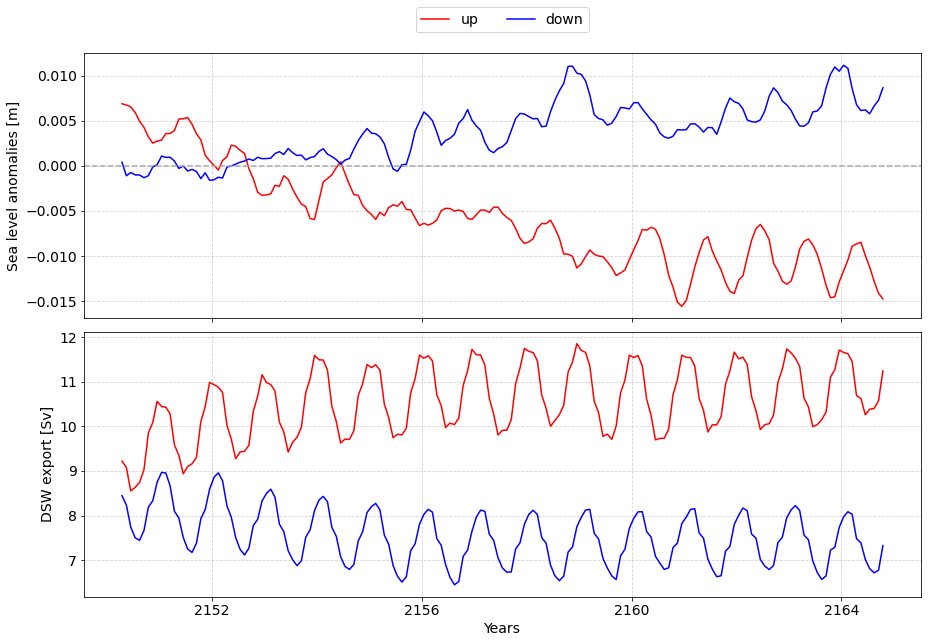

In [61]:
plt.rcParams['font.size'] = 14
fig = plt.figure(figsize = (15, 10))
axs = [fig.add_subplot(211), fig.add_subplot(212)]
plt.subplots_adjust(hspace = 0.05)

for k, clr in zip(['up', 'down'], ['r', 'b']):
    axs[0].plot(slev_anom_mask[k].rolling(time = 6, center = True).mean('time')['time'], slev_anom_mask[k].rolling(time = 6, center = True).mean('time'), color = clr, label = k)
axs[1].plot(DSW_export_up.rolling(time = 6, center = True).mean('time')['time'], DSW_export_up.rolling(time = 6, center = True).mean('time'), color = 'r')
axs[1].plot(DSW_export_do.rolling(time = 6, center = True).mean('time')['time'], DSW_export_do.rolling(time = 6, center = True).mean('time'), color = 'b')

axs[0].legend(ncol = 2, loc = 'upper center', bbox_to_anchor = (0.5,1.2))

axs[0].set_xticklabels([])
axs[0].axhline(y = 0, color = 'darkgrey', linestyle = '--')
axs[0].grid(linestyle = '--', color = 'lightgrey')
axs[1].grid(linestyle = '--', color = 'lightgrey')
axs[0].set_ylabel('Sea level anomalies [m]')
axs[1].set_xlabel('Years')
axs[1].set_ylabel('DSW export [Sv]')

# Overturning

In [62]:
ty = {}
ty['ctrl'] = cc.querying.getvar(experiment_ryf, 'ty_trans_rho', session_ryf, start_time = ti, end_time = tf).sel(grid_yu_ocean = slice(None, -50))
ty['up'] = cc.querying.getvar(experiment_eup, 'ty_trans_rho', session_eas, start_time = ti, end_time = tf).sel(grid_yu_ocean = slice(None, -50))
ty['down'] = cc.querying.getvar(experiment_edo, 'ty_trans_rho', session_eas, start_time = ti, end_time = tf).sel(grid_yu_ocean = slice(None, -50))

In [63]:
psi = {}
for k in ['ctrl', 'up', 'down']:
    psi[k] = ty[k]/(1025*1e6)
    psi[k] = psi[k].sum('grid_xt_ocean')

In [64]:
psi_overturning = {}
for k in ['ctrl', 'up', 'down']:
    psi_overturning[k] = psi[k].cumsum('potrho') - psi[k].sum('potrho')

In [76]:
max_transport = {}
for k in ['ctrl', 'up', 'down']:
    max_transport[k] = -psi_overturning[k].sel(grid_yu_ocean = -55, method = 'nearest').min('potrho')

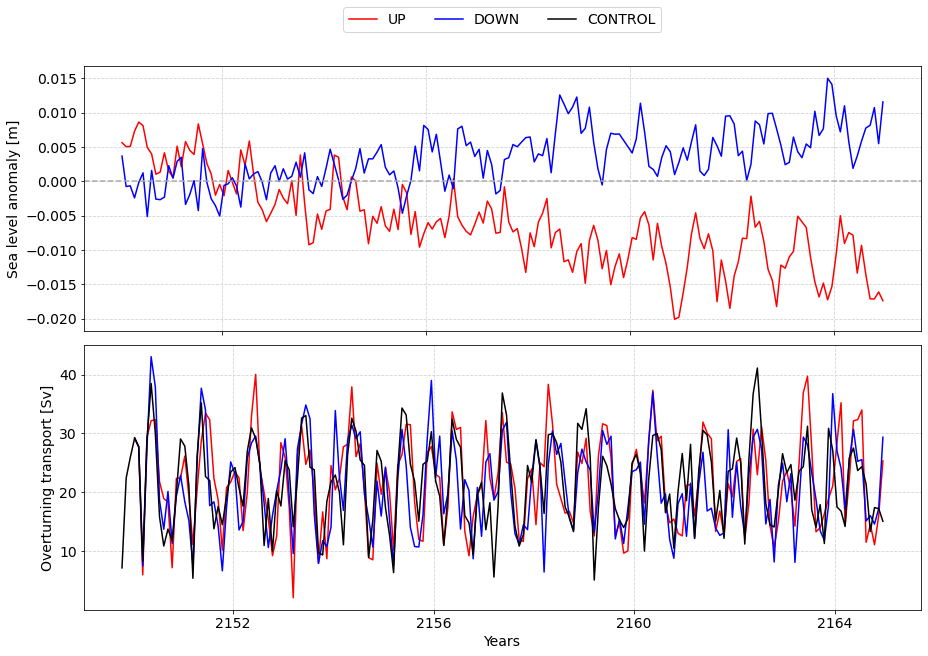

In [85]:
plt.rcParams['font.size'] = 14
fig = plt.figure(figsize = (15, 10))
axs = [fig.add_subplot(211), fig.add_subplot(212)]
plt.subplots_adjust(hspace = 0.05)

axs[0].plot(slev_anom_mask['up']['time'], slev_anom_mask['up'], color = 'r')
axs[0].plot(slev_anom_mask['down']['time'], slev_anom_mask['down'], color = 'b')

axs[1].plot(max_transport['up']['time'], max_transport['up'], color = 'r', label = 'UP')
axs[1].plot(max_transport['down']['time'], max_transport['down'], color = 'b', label = 'DOWN')
axs[1].plot(max_transport['ctrl']['time'], max_transport['ctrl'], color = 'k', label = 'CONTROL')
axs[1].legend(ncol = 3, loc = 'upper center', bbox_to_anchor = (0.5,2.3))

axs[0].set_xticklabels([])
axs[0].axhline(y = 0, color = 'darkgrey', linestyle = '--')
axs[0].grid(linestyle = '--', color = 'lightgrey')
axs[1].grid(linestyle = '--', color = 'lightgrey')
axs[0].set_ylabel('Sea level anomaly [m]')
axs[1].set_xlabel('Years')
axs[1].set_ylabel('Overturning transport [Sv]')

plt.savefig(figdir + 'figure-2-v0.jpg', bbox_inches = 'tight')